In [1]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import joblib

from astropy.io import fits
from functools import reduce
from astropy.table import Table

sys.path.append('../../methods_code_Nresol/')
sys.path.append('../../utils/')
import astro_cuts
import importlib
import spec_utils

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [3]:
fname = 'lsd_scripts/spectrain_2_11_r50.fits'
df_allspec = spec_utils.convert_to_dataframe_specmatched(fname)
df_goodspec = spec_utils.return_goodspec(df_allspec)

/n/holylfs05/LABS/finkbeiner_lab/Everyone/highlat/notebooks_main1/spectra_matched/spec_utils.py:36: RuntimeWarning: divide by zero encountered in true_divide
  df['reduced_chisq'] = df['chisq'].to_numpy() * n_passbands / (n_passbands - 4)
/n/holylfs05/LABS/finkbeiner_lab/Everyone/highlat/notebooks_main1/spectra_matched/spec_utils.py:40: RuntimeWarning: divide by zero encountered in power
  sdss_flux_sig = np.power(np.array(dat['sdss_dr14_starsweep.psfflux_ivar']), -0.5)
/n/holylfs05/LABS/finkbeiner_lab/Everyone/highlat/notebooks_main1/spectra_matched/spec_utils.py:42: RuntimeWarning: divide by zero encountered in log10
  df['sdss.pmag_'+b] = 22.5 - 2.5*np.clip(np.log10(np.array(dat['sdss_dr14_starsweep.psfflux'])[:, ib]), 0.0, np.inf)
/n/holylfs05/LABS/finkbeiner_lab/Everyone/highlat/notebooks_main1/spectra_matched/spec_utils.py:42: RuntimeWarning: invalid value encountered in log10
  df['sdss.pmag_'+b] = 22.5 - 2.5*np.clip(np.log10(np.array(dat['sdss_dr14_starsweep.psfflux'])[:, ib]),

Number of objects before / after 596315 210713
c1 = 0.873, c2 = 0.995, c3 = 0.445
Fraction left = 0.353


In [4]:
len(df_goodspec)

210713

#### Cuts on SDSS

In [5]:
df_goodspec.columns[[c.startswith('sdss.pmag_err_') for c in df_goodspec.columns]]

Index(['sdss.pmag_err_u', 'sdss.pmag_err_g', 'sdss.pmag_err_r',
       'sdss.pmag_err_i', 'sdss.pmag_err_z'],
      dtype='object')

In [6]:
df_goodspec[['sdss.pmag_err_u', 'sdss.pmag_err_g', 'sdss.pmag_err_r']]

,sdss.pmag_err_u,sdss.pmag_err_g,sdss.pmag_err_r
2,0.031511,0.026992,0.031721
3,0.022445,0.033421,0.017240
7,0.022401,0.018154,0.018323
9,0.018438,0.020665,0.020655
10,0.059673,0.023163,0.022950
...,...,...,...
596290,0.023549,0.015549,0.014748
596291,0.033583,0.033470,0.018102
596296,0.025078,0.013106,0.014309
596298,0.017442,0.019180,0.015096


In [7]:
def sdss_cuts(df_input):
    #ugr < 0.2
    sdss_magcols = ['sdss.pmag_u', 'sdss.pmag_g', 'sdss.pmag_r']
    sdss_magerrs = ['sdss.pmag_err_u', 'sdss.pmag_err_g', 'sdss.pmag_err_r']
    sdss_pmag_err = df_input[sdss_magerrs].to_numpy()
    cut1 = np.all(sdss_pmag_err <0.2, axis=1)
    
    #ugr arent nan
    cut2 = ~(np.isnan(df_input['sdss.pmag_u'].to_numpy()) + np.isnan(df_input['sdss.pmag_g'].to_numpy()) + np.isnan(df_input['sdss.pmag_r'].to_numpy()))
    
    #negative errs
    cut3 = ~np.any(df_input[sdss_magerrs].iloc[:, :3].to_numpy() < 0, axis=1)
    
    #saturated on faint end
    cut4 = ~np.any(df_input[sdss_magcols].iloc[:, :3].to_numpy() == 22.5, axis=1)
    print('C1: {:.2f} C2: {:.2f} C3: {:.2f} C4: {:.2f}'.format(np.sum(cut1)/len(cut1), np.sum(cut2)/len(cut2), np.sum(cut3)/len(cut3), np.sum(cut4)/len(cut4)))
    
    effcut = cut1 * cut2 * cut3 * cut4
    
    return effcut

In [8]:
cleanphot = sdss_cuts(df_goodspec)
df_sdss = df_goodspec.iloc[cleanphot, :]
np.sum(cleanphot)/len(cleanphot)

C1: 0.97 C2: 1.00 C3: 1.00 C4: 0.98


0.9657306383564375

In [9]:
len(df_sdss)

203492

In [10]:
train_x, train_y, test_x, test_y = spec_utils.return_train_test_subset(df_sdss, ['u-g_sdss', 'g-r_sdss'], balance_train=False)

NumTrain, NumTest =  142443 61049
Train Class Fraction: Q = 0.17049626868291176
Test Class Fraction: Q = 0.1705023833314223


In [21]:
'''from sklearn.svm import SVC
model = SVC(kernel='rbf')
model.fit(train_x, train_y)
model.score(train_x, train_y), model.score(test_x, test_y)'''

(0.9828984225269055, 0.9823092925355043)

In [22]:
'''import joblib
joblib.dump(model, 'models/svm_sdss_quasarsep_unbalanced.joblib')'''

['models/svm_sdss_quasarsep_unbalanced.joblib']

In [12]:
#Not retraining and loading the already saved model instead
import joblib
smodel = joblib.load('models/svm_sdss_quasarsep_unbalanced.joblib')

In [16]:
plt.rcParams.update({'font.family':'serif'})

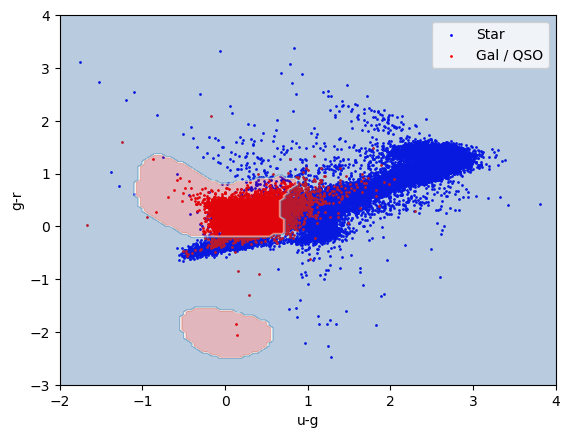

In [14]:
h=0.05
x_min, x_max = train_x[:, 0].min() - 1, train_x[:, 0].max() + 1
y_min, y_max = train_x[:, 1].min() - 1, train_x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = smodel.predict(np.vstack([xx.ravel(), yy.ravel()]).T)
Z = Z.reshape(xx.shape)

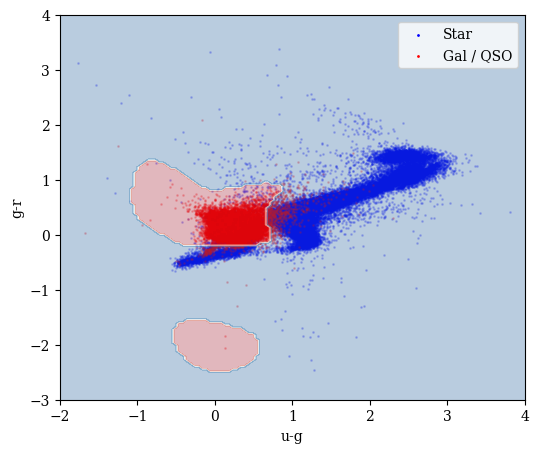

In [24]:
plt.figure(figsize=(6, 5))
plt.scatter(train_x[train_y==1, 0], train_x[train_y==1, 1], label='Star', s=1, c='b', alpha=0.2)
plt.scatter(train_x[train_y==0, 0], train_x[train_y==0, 1], label='Gal / QSO', s=1, c='r', alpha=0.2)
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.3)


plt.xlabel('u-g')
plt.ylabel('g-r')
plt.xlim(-2, 4)
plt.ylim(-3, 4)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.savefig('../../plots/sdss_4_23.png')
plt.show()

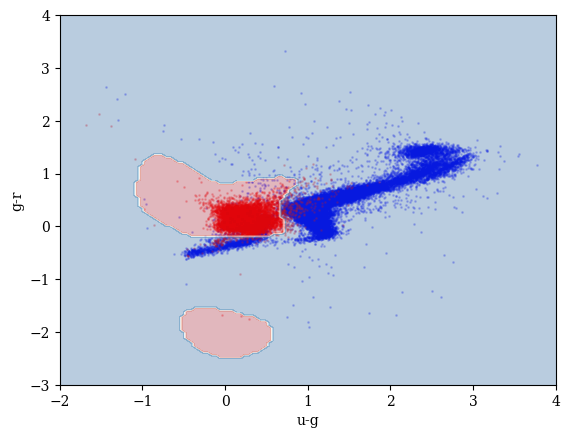

In [19]:
plt.figure()
plt.scatter(test_x[test_y==1, 0], test_x[test_y==1, 1], label='Star', s=1, c='b', alpha=0.2)
plt.scatter(test_x[test_y==0, 0], test_x[test_y==0, 1], label='Gal / QSO', s=1, c='r', alpha=0.2)
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.3)


plt.xlabel('u-g')
plt.ylabel('g-r')
plt.xlim(-2, 4)
plt.ylim(-3, 4)
plt.savefig('../../plots/sdss_4_23_test.png')
plt.show()